# Importing the needed libraries and load dataset

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import ShuffleSplit 
from sklearn.model_selection import cross_val_score

## Exploring the Dataset 

In [2]:
dataTrain = pd.read_csv("train_V2.csv")
dataTest = pd.read_csv("test_V2.csv")

In [3]:
dataTrain.head(5)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,...,0,0.0000,0,0.00,0,0,244.80,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,...,0,0.0045,0,11.04,0,0,1434.00,5,0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,...,0,0.0000,0,0.00,0,0,161.80,2,0,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,...,0,0.0000,0,0.00,0,0,202.70,3,0,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,...,0,0.0000,0,0.00,0,0,49.75,2,0,0.1875


In [4]:
dataTrain.tail(5)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
4446961,afff7f652dbc10,d238e426f50de7,18492834ce5635,0,0,0.00,0,0,0,74,...,0,1292.0,0,0.000,0,0,1019.0,3,1507,0.1786
4446962,f4197cf374e6c0,408cdb5c46b2ac,ee854b837376d9,0,1,44.15,0,0,0,69,...,0,0.0,0,0.000,0,0,81.7,6,0,0.2935
4446963,e1948b1295c88a,e26ac84bdf7cef,6d0cd12784f1ab,0,0,59.06,0,0,0,66,...,0,0.0,0,2.184,0,0,788.7,4,0,0.4815
4446964,cc032cdd73b7ac,c2223f35411394,c9c701d0ad758a,0,4,180.40,1,1,2,11,...,2,0.0,0,0.000,0,0,2748.0,8,0,0.8000
4446965,0d8e7ed728b6fd,8c74f72fedf5ff,62a16aabcc095c,0,2,268.00,0,0,1,18,...,0,1369.0,0,0.000,0,0,1244.0,5,0,0.5464


## Data fields
- DBNOs - Number of enemy players knocked.
- assists - Number of enemy players this player damaged that were killed by teammates.
- boosts - Number of boost items used.
- damageDealt - Total damage dealt. Note: Self inflicted damage is subtracted.
- headshotKills - Number of enemy players killed with headshots.
- heals - Number of healing items used.
- Id - Player’s Id
- killPlace - Ranking in match of number of enemy players killed.
- killPoints - Kills-based external ranking of player. (Think of this as an Elo ranking where only kills matter.) If there is a value other than -1 in rankPoints, then any 0 in killPoints should be treated as a “None”.
- killStreaks - Max number of enemy players killed in a short amount of time.
- kills - Number of enemy players killed.
- longestKill - Longest distance between player and player killed at time of death. This may be misleading, as downing a player and driving away may lead to a large longestKill stat.
- matchDuration - Duration of match in seconds.
- matchId - ID to identify match. There are no matches that are in both the training and testing set.
- matchType - String identifying the game mode that the data comes from. The standard modes are “solo”, “duo”, “squad”, “solo-fpp”, “duo-fpp”, and “squad-fpp”; other modes are from events or custom matches.
- rankPoints - Elo-like ranking of player. This ranking is inconsistent and is being deprecated in the API’s next version, so use with caution. Value of -1 takes place of “None”.
- revives - Number of times this player revived teammates.
- rideDistance - Total distance traveled in vehicles measured in meters.
- roadKills - Number of kills while in a vehicle.
- swimDistance - Total distance traveled by swimming measured in meters.
- teamKills - Number of times this player killed a teammate.
- vehicleDestroys - Number of vehicles destroyed.
- walkDistance - Total distance traveled on foot measured in meters.
- weaponsAcquired - Number of weapons picked up.
- winPoints - Win-based external ranking of player. (Think of this as an Elo ranking where only winning matters.) If there is a value other than -1 in rankPoints, then any 0 in winPoints should be treated as a “None”.
- groupId - ID to identify a group within a match. If the same group of players plays in different matches, they will have a different groupId each time.
- numGroups - Number of groups we have data for in the match.
- maxPlace - Worst placement we have data for in the match. This may not match with numGroups, as sometimes the data skips over placements.
- winPlacePerc - The target of prediction. This is a percentile winning placement, where 1 corresponds to 1st place, and 0 corresponds to last place in the match. It is calculated off of maxPlace, not numGroups, so it is possible to have missing chunks in a match.

In [5]:
dataTrain.shape

(4446966, 29)

In [6]:
dataTrain.describe()

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
count,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,...,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446965e+06
mean,2.338149e-01,1.106908e+00,1.307171e+02,6.578755e-01,2.268196e-01,1.370147e+00,4.759935e+01,5.050060e+02,9.247833e-01,5.439551e-01,...,1.646590e-01,6.061157e+02,3.496091e-03,4.509322e+00,2.386841e-02,7.918208e-03,1.154218e+03,3.660488e+00,6.064601e+02,4.728216e-01
std,5.885731e-01,1.715794e+00,1.707806e+02,1.145743e+00,6.021553e-01,2.679982e+00,2.746294e+01,6.275049e+02,1.558445e+00,7.109721e-01,...,4.721671e-01,1.498344e+03,7.337297e-02,3.050220e+01,1.673935e-01,9.261157e-02,1.183497e+03,2.456544e+00,7.397004e+02,3.074050e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.400000e+01,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.551000e+02,2.000000e+00,0.000000e+00,2.000000e-01
50%,0.000000e+00,0.000000e+00,8.424000e+01,0.000000e+00,0.000000e+00,0.000000e+00,4.700000e+01,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.856000e+02,3.000000e+00,0.000000e+00,4.583000e-01
75%,0.000000e+00,2.000000e+00,1.860000e+02,1.000000e+00,0.000000e+00,2.000000e+00,7.100000e+01,1.172000e+03,1.000000e+00,1.000000e+00,...,0.000000e+00,1.909750e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.976000e+03,5.000000e+00,1.495000e+03,7.407000e-01
max,2.200000e+01,3.300000e+01,6.616000e+03,5.300000e+01,6.400000e+01,8.000000e+01,1.010000e+02,2.170000e+03,7.200000e+01,2.000000e+01,...,3.900000e+01,4.071000e+04,1.800000e+01,3.823000e+03,1.200000e+01,5.000000e+00,2.578000e+04,2.360000e+02,2.013000e+03,1.000000e+00


In [7]:
dataTrain.nunique()

Id                 4446966
groupId            2026745
matchId              47965
assists                 20
boosts                  27
damageDealt          29916
DBNOs                   39
headshotKills           34
heals                   63
killPlace              101
killPoints            1707
kills                   58
killStreaks             18
longestKill          28284
matchDuration         1267
matchType               16
maxPlace               100
numGroups              100
rankPoints            2262
revives                 25
rideDistance         33562
roadKills               14
swimDistance         28345
teamKills               11
vehicleDestroys          6
walkDistance         38599
weaponsAcquired         97
winPoints             1447
winPlacePerc          3000
dtype: int64

## Check for missing values

In [8]:
dataTrain.isnull().sum()

Id                 0
groupId            0
matchId            0
assists            0
boosts             0
damageDealt        0
DBNOs              0
headshotKills      0
heals              0
killPlace          0
killPoints         0
kills              0
killStreaks        0
longestKill        0
matchDuration      0
matchType          0
maxPlace           0
numGroups          0
rankPoints         0
revives            0
rideDistance       0
roadKills          0
swimDistance       0
teamKills          0
vehicleDestroys    0
walkDistance       0
weaponsAcquired    0
winPoints          0
winPlacePerc       1
dtype: int64

In [9]:
dataTest.isnull().sum()

Id                 0
groupId            0
matchId            0
assists            0
boosts             0
damageDealt        0
DBNOs              0
headshotKills      0
heals              0
killPlace          0
killPoints         0
kills              0
killStreaks        0
longestKill        0
matchDuration      0
matchType          0
maxPlace           0
numGroups          0
rankPoints         0
revives            0
rideDistance       0
roadKills          0
swimDistance       0
teamKills          0
vehicleDestroys    0
walkDistance       0
weaponsAcquired    0
winPoints          0
dtype: int64

We can see their that we have one mising value in our dataset

Let us now check the data types of each attribut

In [10]:
dataTrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446966 entries, 0 to 4446965
Data columns (total 29 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Id               object 
 1   groupId          object 
 2   matchId          object 
 3   assists          int64  
 4   boosts           int64  
 5   damageDealt      float64
 6   DBNOs            int64  
 7   headshotKills    int64  
 8   heals            int64  
 9   killPlace        int64  
 10  killPoints       int64  
 11  kills            int64  
 12  killStreaks      int64  
 13  longestKill      float64
 14  matchDuration    int64  
 15  matchType        object 
 16  maxPlace         int64  
 17  numGroups        int64  
 18  rankPoints       int64  
 19  revives          int64  
 20  rideDistance     float64
 21  roadKills        int64  
 22  swimDistance     float64
 23  teamKills        int64  
 24  vehicleDestroys  int64  
 25  walkDistance     float64
 26  weaponsAcquired  int64  
 27  winPoints   

Now let us detect which columns have symbols and if there are any other symbols too.

In [11]:
#Checking for wrong entries like symbols -,?,#,*,etc.
for col in dataTrain.columns:
    print('{}:{}'.format(col,dataTrain[col].unique()))

Id:['7f96b2f878858a' 'eef90569b9d03c' '1eaf90ac73de72' ... 'e1948b1295c88a'
 'cc032cdd73b7ac' '0d8e7ed728b6fd']
groupId:['4d4b580de459be' '684d5656442f9e' '6a4a42c3245a74' ... 'ac3f1b4a56e5ad'
 '408cdb5c46b2ac' '8c74f72fedf5ff']
matchId:['a10357fd1a4a91' 'aeb375fc57110c' '110163d8bb94ae' ... '21beed46753ed9'
 '224a123c53e008' 'fcad6c3fdd847a']
assists:[ 0  1  3  2  4  6  5  8  9  7 13 11 12 21 10 20 14 17 22 15]
boosts:[ 0  1  2  3  4  6  5  9  7  8 11 10 13 14 12 21 15 20 16 17 33 19 18 24
 28 23 22]
damageDealt:[ 0.     91.47   68.     ...  6.828   0.8276  0.8705]
DBNOs:[ 0  1  6  4  3  2  5 10  8  7  9 13 21 12 11 19 32 18 24 22 20 14 15 26
 17 16 25 27 23 33 38 30 29 31 39 35 40 28 53]
headshotKills:[ 0  1  2  3  6  4  5  8  9  7 17 10 14 12 40 11 13 15 16 18 27 19 21 23
 42 31 20 46 39 34 26 64 41 35]
heals:[ 0  5  2 14 12  1  8  3  4  6  9 13  7 24 10 15 25 11 18 17 20 16 29 23
 19 21 22 27 28 32 47 26 31 30 43 33 37 34 38 52 35 42 48 40 41 44 39 45
 36 61 46 57 63 50 55 49 59 54

In [12]:
for col in dataTest.columns:
    print('{}:{}'.format(col,dataTest[col].unique()))

Id:['9329eb41e215eb' '639bd0dcd7bda8' '63d5c8ef8dfe91' ... 'fc8818b5b32ad3'
 'a0f91e35f8458f' '3696fc9f3a42b2']
groupId:['676b23c24e70d6' '430933124148dd' '0b45f5db20ba99' ... '355623b5def3e6'
 'a64e0c1ca94fb2' 'f430f8a8efe1e9']
matchId:['45b576ab7daa7f' '42a9a0b906c928' '87e7e4477a048e' ... '9fd1df68453821'
 'f95c5558053880' 'd2cd46eed660e1']
assists:[ 0  1  4  2  3  5 10  6  7  9 14 17  8 13 12 18 11 16 15 27 22 25 19 24]
boosts:[ 0  4  3  2  5  1  6  7 13  9 10  8 12 11 14 19 15 24 16 23 17 20 18]
damageDealt:[5.146e+01 1.791e+02 2.340e+01 ... 4.713e+03 7.000e-02 1.210e+00]
DBNOs:[ 0  1  3  2  4  5 12  7  6  8 11 10  9 13 20 18 31 16 15 25 19 14 27 17
 23 26 24 21 28 38 32 59 35 22 29 44]
headshotKills:[ 0  2  1  3  6  4  5 12  7  8 11 21  9 10 18 15 23 13 14 16 27 41 19 17
 24]
heals:[ 0  2  4  1 17  6  5  8  3 10  7 16 11  9 15 14 12 18 19 13 25 21 20 23
 28 32 26 30 24 22 27 34 44 29 36 33 38 41 31 35 39 37 56 40 43 75 47 50
 42 48 54 45 63 52 49 51]
killPlace:[ 73  11  49  54   

winPoints:[   0 1495 1538 ...  321  799  849]


Good, It seems that we don't have any unique symbols 

Let us check the dublicated rows 

In [13]:
dataTrain_dup = dataTrain[dataTrain.duplicated()]
print('you have {} duplicated rows'.format(len(dataTrain_dup)))

you have 0 duplicated rows


In [14]:
dataTest_dup = dataTest[dataTest.duplicated()]
print('you have {} duplicated rows'.format(len(dataTest_dup)))

you have 0 duplicated rows


Great we don't have any duplicated rows

Now let us get rid of nulls 

In [15]:
dataTrain = dataTrain.dropna()

## Feature Engineering 
Now let's creat some interesting features.

I have created 6 more features: 
- overAllDistance
- headShotPercentage
- killsPerDistance
- totalBoosts/Heals
- damagePerKills 
- sKill

In [16]:
dataTrain['overAllDistance'] = dataTrain['rideDistance'] + dataTrain['swimDistance'] + dataTrain['walkDistance']
dataTest['overAllDistance'] = dataTest['rideDistance'] + dataTest['swimDistance'] + dataTest['walkDistance']

#Calculating headshots percentage 
dataTrain['headShotPercentage'] = dataTrain[['kills','headshotKills']].apply(lambda x:
x['headshotKills']/x['kills'] if x['kills'] > 0 else 0, axis=1)
dataTest['headShotPercentage'] = dataTest[['kills','headshotKills']].apply(lambda x:
x['headshotKills']/x['kills'] if x['kills'] > 0 else 0, axis=1)
#if kills are 0 returning 0 else 'heashotKills' by 'kills'

dataTrain['killsPerDistance'] = dataTrain[['kills','overAllDistance']].apply(lambda x : x['kills']/x['overAllDistance'] if x['overAllDistance'] > 0 else 0, axis=1)
dataTest['killsPerDistance'] = dataTest[['kills','overAllDistance']].apply(lambda x : x['kills']/x['overAllDistance'] if x['overAllDistance'] > 0 else 0, axis=1)
#If overAllDistance is greater than 0 return 0 else return 'kills' by 'overAllDistance'

dataTrain['totalBoosts/Heals'] = dataTrain['boosts'] + dataTrain['heals']
dataTest['totalBoosts/Heals'] = dataTest['boosts'] + dataTest['heals']
#sum of boosts anf heals 

dataTrain['damagePerKill'] = dataTrain.apply(lambda x: x['damageDealt']/x['kills'] if x['kills']>0 else 0, axis=1)
dataTest['damagePerKill'] = dataTest.apply(lambda x: x['damageDealt']/x['kills'] if x['kills']>0 else 0, axis=1)
#damge delt per kill 

dataTrain['sKill'] = dataTrain['headshotKills'] + dataTrain['roadKills']
dataTest['sKill'] = dataTest['headshotKills'] + dataTest['roadKills']



In [17]:
dataTrain=dataTrain.drop(['rideDistance','swimDistance','walkDistance','headshotKills', 'roadKills','boosts','heals','rankPoints'], axis = 1)
dataTest=dataTest.drop(['rideDistance','swimDistance','walkDistance','headshotKills', 'roadKills','boosts','heals','rankPoints'], axis = 1)

## Asking Analytical Questions and Visualizations

Before this let us check the correlation between different variables, this will give us a roadmap on how to proceed further.

<AxesSubplot:>

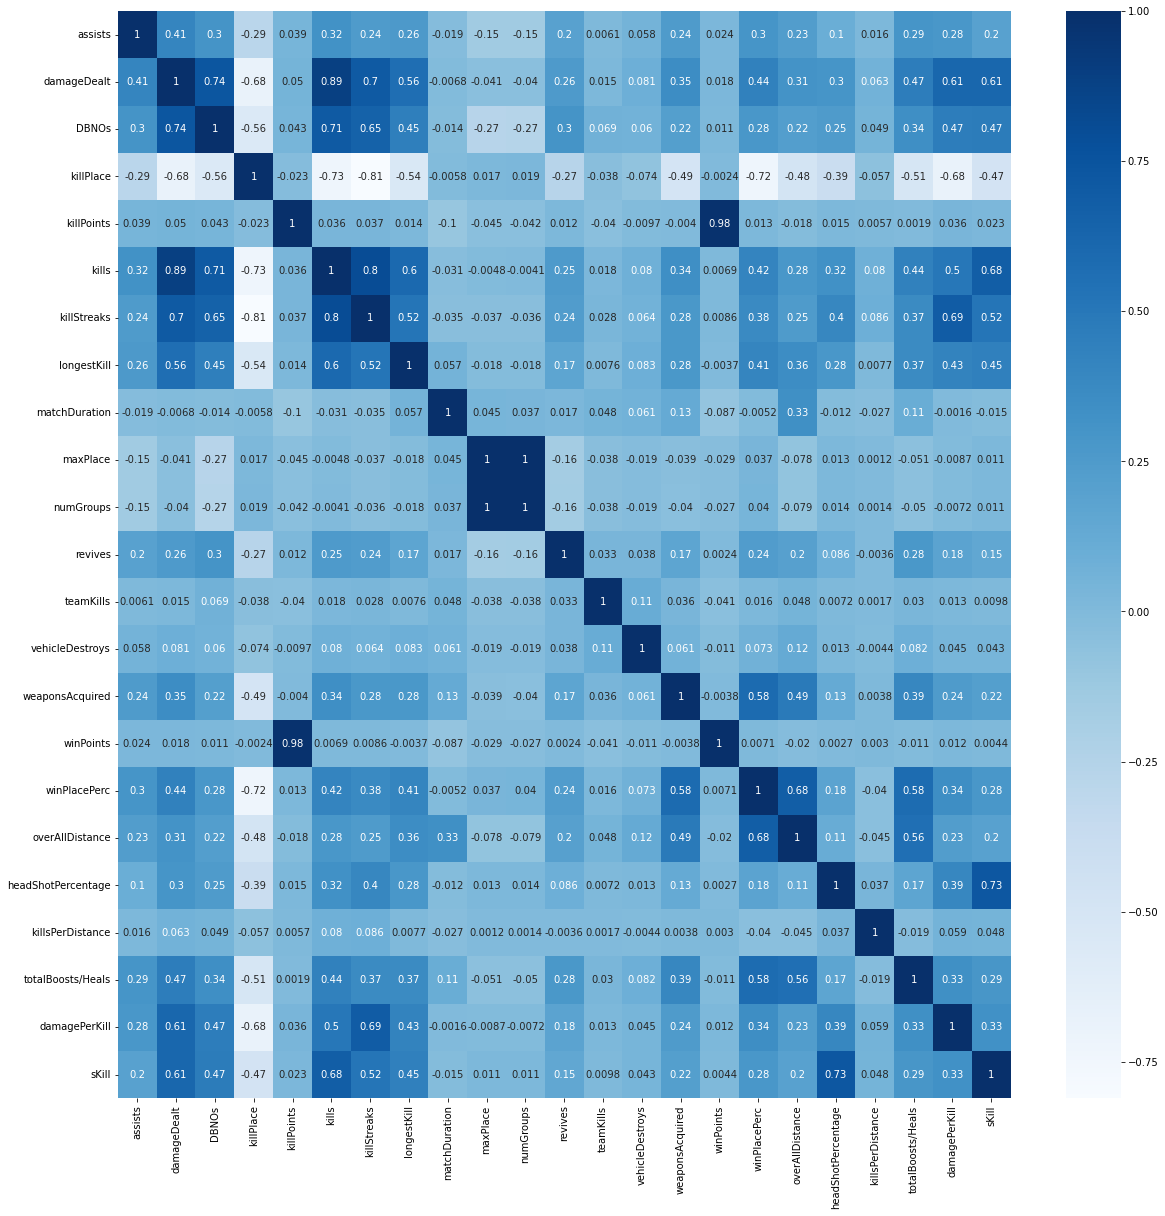

In [18]:
plt.subplots(figsize=(20,20))
sns.heatmap(dataTrain.corr(),cbar=True,annot=True,cmap='Blues')

## Positive Correlation
- winPlacePerc – overAllDistance, totalBoosts/Heals, weaponAcquired
- winPoints – killPoints
- weaponAcquired – overAllDistance 
- overAllDistance – totalBoosts/Heals, weaponsAcquired
- longestKills – kills, damegeDealt
- killStreaks – kills, damegeDealt, DBNOs
- kills – damgeDealt, DBNOs,boosts
- heals – boosts
- DBNOs – damgeDealt
- damgeDealt – kills,longestKill, killStreaks, boosts

## Negative Correlation 
- winPlacePerc – killPlace 
- overAllDistance – killPlace 
- longestKills – killPlace 
- killStreaks – killPlace 
- kills – killPlace 
- killPlace – damageDealt,totalBoosts/Heals
- DBNOs – killPlace 

we can notice here that killPlace has a negative correlation in a good amount of features 

This heatmap has given us great insights into the data. 

Now let us apply domain knowledge and ask questions. 

## 1- How does the distance affect the winning percentile? 

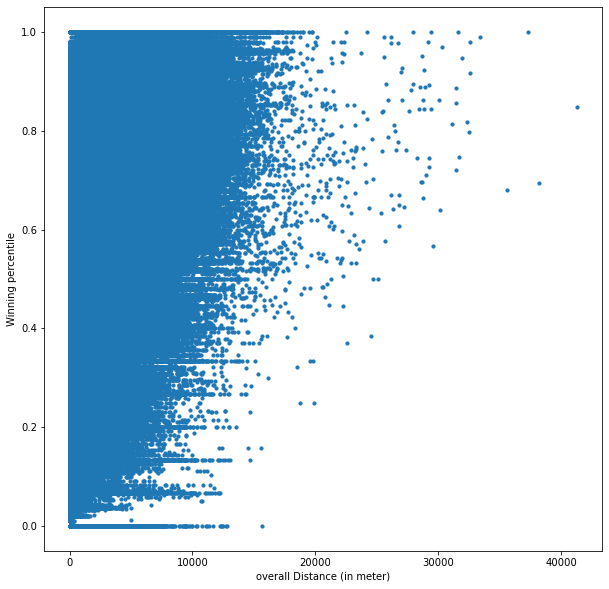

In [19]:
plt.figure(figsize=(10,10))
plt.scatter(x='overAllDistance',y='winPlacePerc', s= 10,data = dataTrain)
plt.xlabel('overall Distance (in meter)')
plt.ylabel('Winning percentile')
plt.show()

We can see here that the more the player walked the more they get chance to win

and most of the players who made nearly 100% winning they have walked around 20000 meter 

but there's a noticeable amount of players walked around 13000 meters and they didn't made any progress in winning and this is understandable because there's a good amount of players who just played it and they don't know anything about it so they just exploring the game  

## 2- How does the weapon acquired affect the winning percentile? 

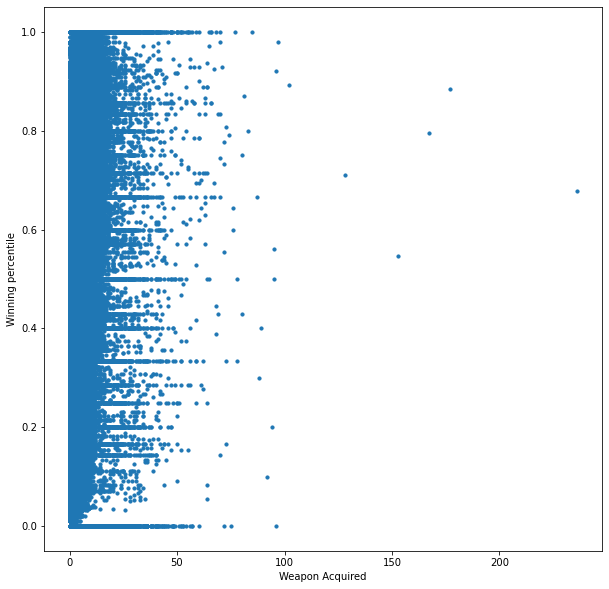

In [20]:
plt.figure(figsize=(10,10))
plt.scatter(x='weaponsAcquired',y='winPlacePerc', s= 10,data = dataTrain)
plt.xlabel('Weapon Acquired')
plt.ylabel('Winning percentile')
plt.show()

It seems that it doesn't matter how many times the player picked up weapons on his winning accuracy 

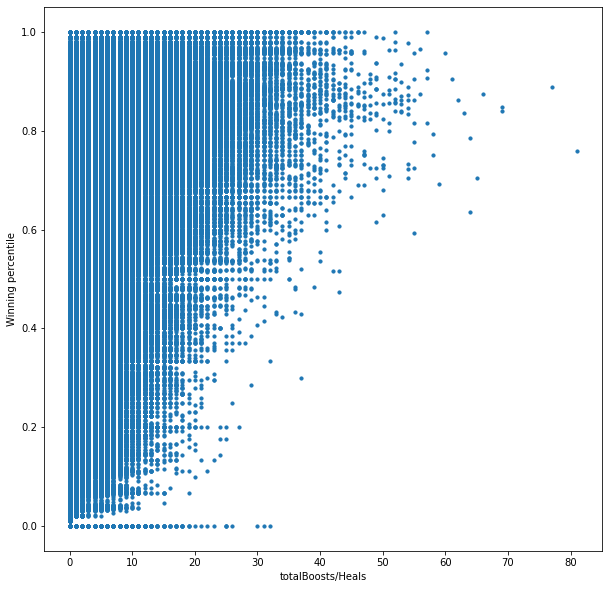

In [21]:
plt.figure(figsize=(10,10))
plt.scatter(x='totalBoosts/Heals',y='winPlacePerc', s= 10,data = dataTrain)
plt.xlabel('totalBoosts/Heals')
plt.ylabel('Winning percentile')
plt.show()

As we already expected the more we take boosts the more they get chance to win 

## 3- There's a high correlation between win points and kill points 
Let us see this in scatter

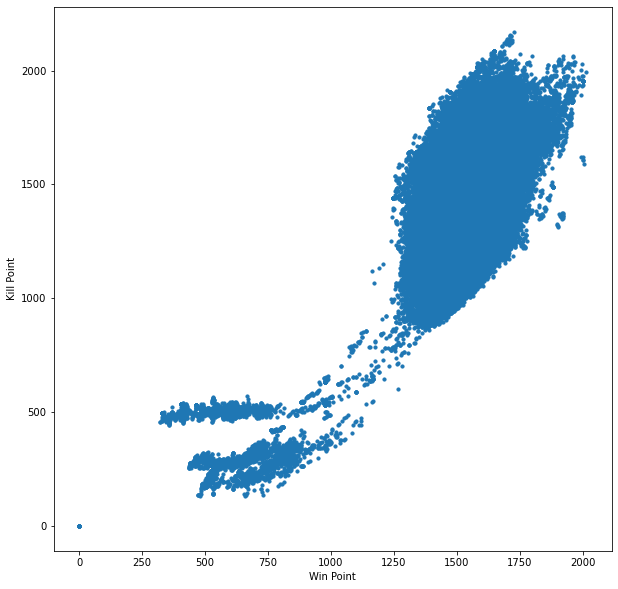

In [22]:
plt.figure(figsize=(10,10))
plt.scatter(x='winPoints',y='killPoints', s= 10,data = dataTrain)
plt.xlabel('Win Point')
plt.ylabel('Kill Point')
plt.show()

We can see here that more than a half of the data has made more than 1000 kill point and 1250 win point 

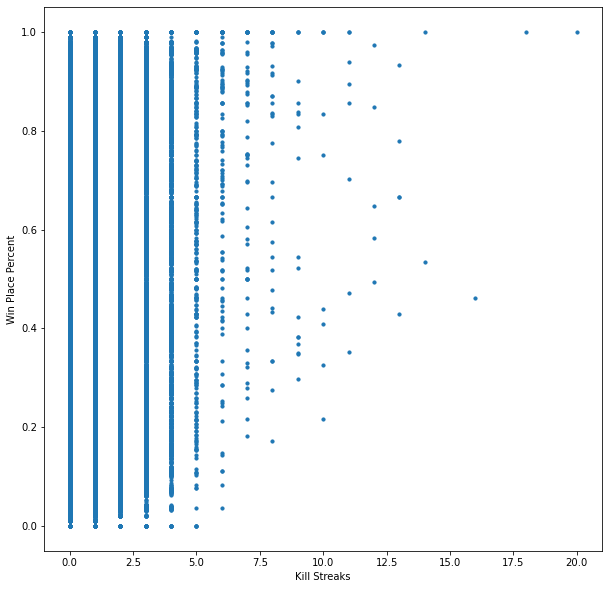

In [23]:
plt.figure(figsize=(10,10))
plt.scatter(x='killStreaks',y='winPlacePerc', s= 10,data = dataTrain)
plt.xlabel('Kill Streaks')
plt.ylabel('Win Place Percent')
plt.show()

## So in summary we can see here the key features that make the player win more frequantly which is the boosts and heals

## 4- What about negative correlation! 

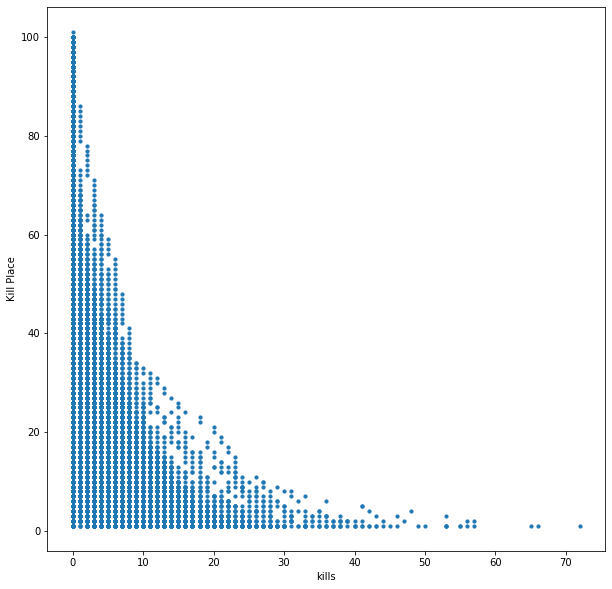

In [24]:
plt.figure(figsize=(10,10))
plt.scatter(x='kills',y='killPlace', s= 10,data = dataTrain)
plt.xlabel('kills')
plt.ylabel('Kill Place')
plt.show()

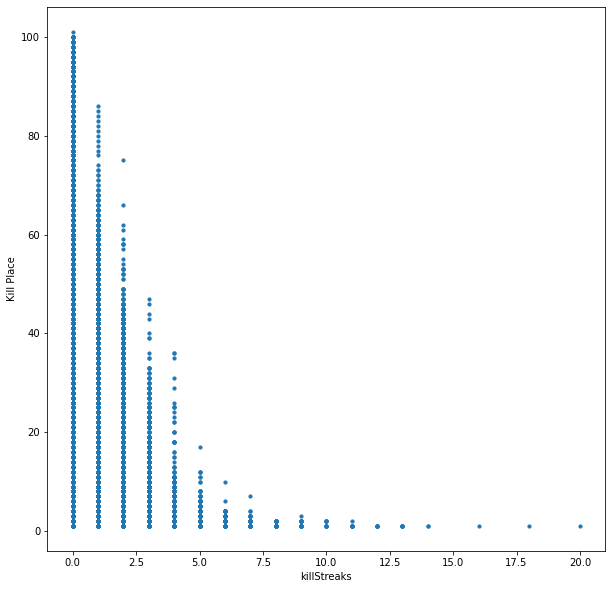

In [25]:
plt.figure(figsize=(10,10))
plt.scatter(x='killStreaks',y='killPlace', s= 10,data = dataTrain)
plt.xlabel('killStreaks')
plt.ylabel('Kill Place')
plt.show()

What we can see here?

This is also normal because the more I kill in the game the more my rank will be decreased to be at the top 

## Now let us start identifying the cheaters/hackers in the game  

As the popularity of the game increased the people started to use different Applications which increased the chance of winning. So I'll use 3 approaches to identify the cheaters/hackers:

- Have a very high headshot percentage.
- Have lots of kills without moving.
- Have acquired lots of weapons without moving.

In [26]:
dataTrain[(dataTrain['headShotPercentage']>0.9) & (dataTrain['kills'] > 40)] [['Id', 'totalBoosts/Heals','headShotPercentage','kills','winPlacePerc']]
#finding outthe cheaters by searching the players with more than 40 kills and 90% of them are from headshots

,Id,totalBoosts/Heals,headShotPercentage,kills,winPlacePerc
160254,15622257cb44e2,0,0.952381,42,1.0
2040545,3e28994fb2950b,2,0.951220,41,1.0


So, there are two players player one with id'15622257cb442e' have got 95% of his kills by headshot without using boosts or heals  and another player with id'3e28994fb2950b' have also got 95% of his kills by headshot with only two heals and boosts. 

2- Have lots of kills without moving. 
If two opponents land at the same place one might get few kills without moving. I'm using a threshold of 10 kills. if any player has more than 10 kills without moving he mihgt be a cheater. For this I'll use the new feature 'overAllDistance'.

Text(0.5, 1.0, 'Frequency of kills by cheaters without movement')

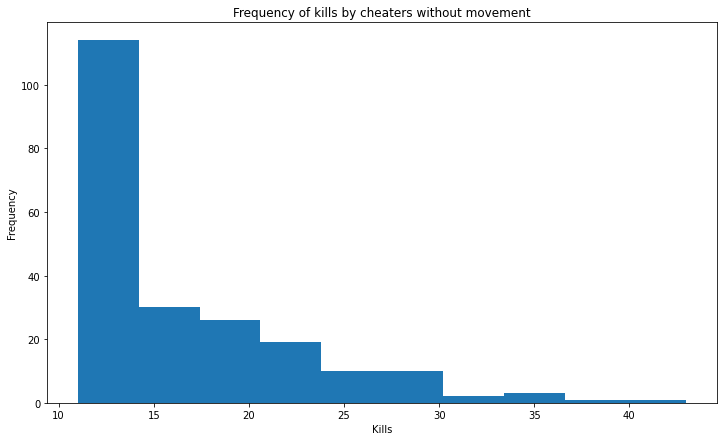

In [27]:
kills_without_movement = dataTrain[(dataTrain['overAllDistance']<=0) & (dataTrain['kills'] > 10)] #Getting the players who had'n moved but got kills more than 10 
kills_without_movement['kills'].plot.hist(figsize=(12,7)) #Ploting the graph to check the frequencey of kills 
plt.xlabel('Kills')
plt.title('Frequency of kills by cheaters without movement')

3- Have acquired lots of weapons without moving.
In PUBG the players land bare hands they have to loot for weapons. There are some cheaters in the game  who may have acquired lots of weaapons without traveling any distance. Let's see if there are any in our dataset. 
For this I'm looking for  playerss who have acquired more than 50 weapons without moving. 

/home/omar/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Frequency of weapons acquired by cheaters')

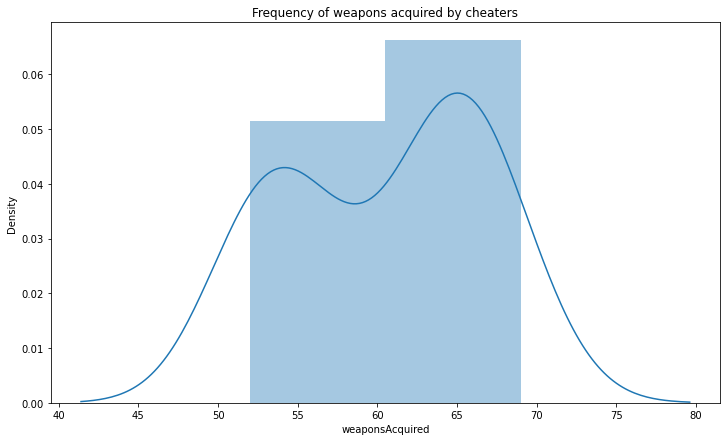

In [28]:
weapons_without_movement = dataTrain[(dataTrain['overAllDistance'] == 0) & (dataTrain['weaponsAcquired'] > 50)]
#players who have more than 50 weapons and has not moved 
fig, ax1 = plt.subplots(figsize=(12,7))
sns.distplot(weapons_without_movement['weaponsAcquired'], ax = ax1)
plt.title('Frequency of weapons acquired by cheaters')

See how the distribution is, there are lotss of cheaters in the dataset. 

Now let's see if there are any players common in both of previous observation, kills witout movement and weapons without movement. 

In [29]:
#Common player in both of previous observations
common_players = [player for player in kills_without_movement['Id'].unique() if player in weapons_without_movement['Id'].unique()]
common_players

['7bfaeb8870182a',
 '96751e22e536ac',
 'd27c9f8ce5b20a',
 '90f6df56893879',
 'e4c109ce8a4baa',
 '2ef7ee0dfd754c',
 '1f5e7e1dceeab0',
 'ad4850b71152ba',
 '4bd90ea103bb02',
 '965e506e0422b1',
 '58667fce89da4b',
 'a89cf0ba9b8ca1',
 '9be002c0f35523',
 '23e46b7521aeca',
 '061cbaa764e319']

There are a total of 15 players who are common in both the observations. I can either:
- dorp each row which have cheater, or 
- drop each entry of these players 

Let's see which match type are cheaters interested in to play. Do they like solo or duo let's see it. 

Text(0.5, 1.0, 'Match type cheaters are interested in')

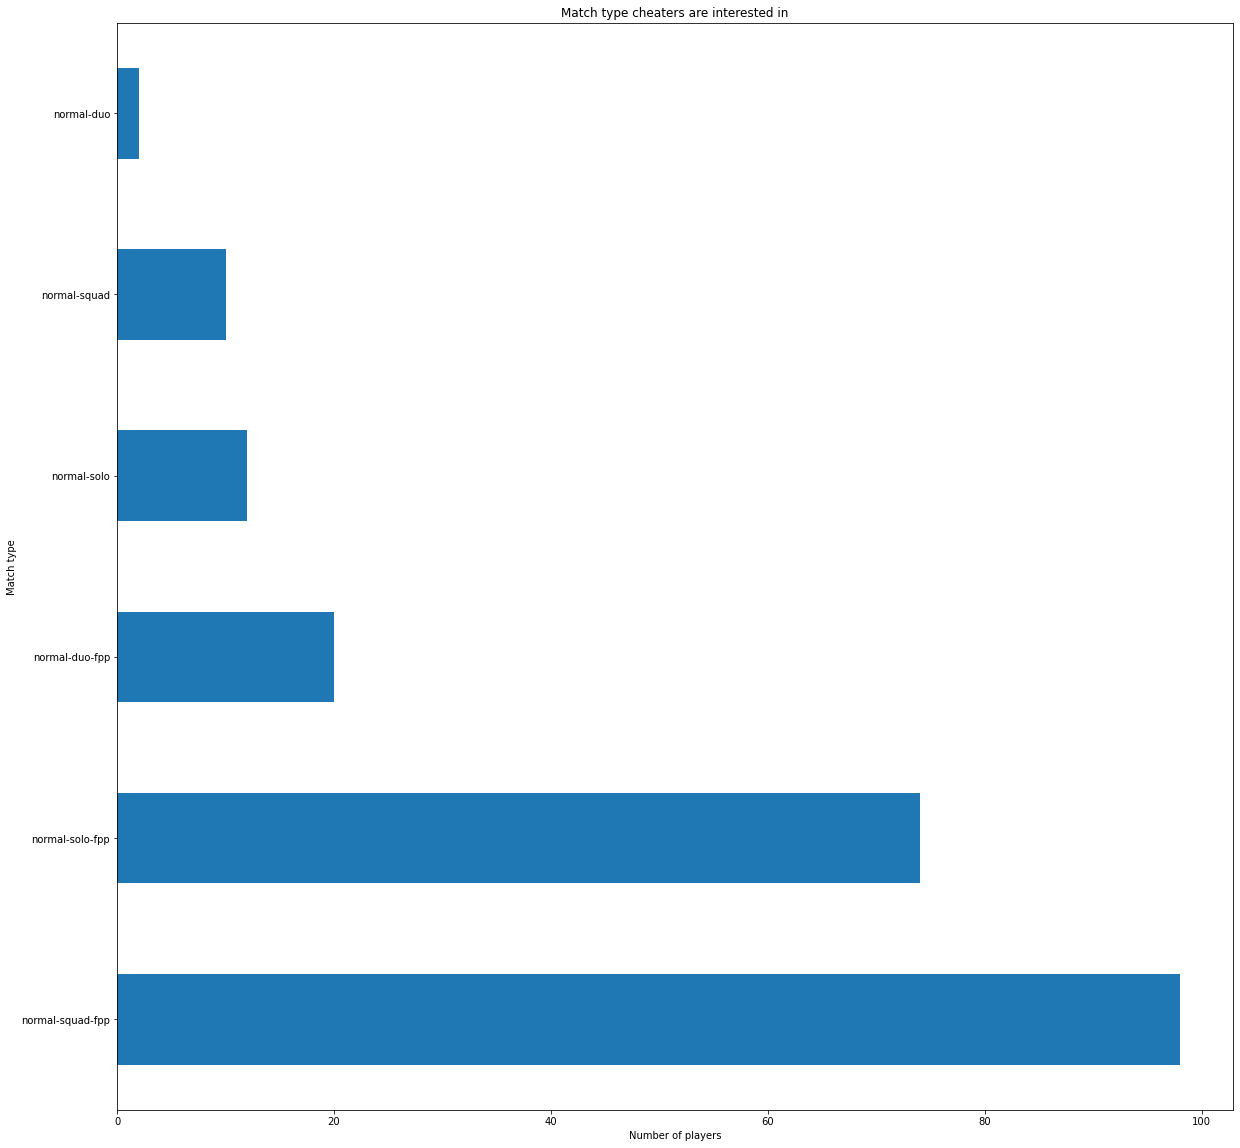

In [30]:
matchType = kills_without_movement['matchType'].value_counts()
#Getting the value count for each match in match type 

matchType.drop(matchType[matchType == 0].index, axis=0, inplace=True)
#dropping the matchType which has 0 value count.

matchType.plot.barh(figsize=(20,20))#plotting a bar plot 

plt.xlabel('Number of players')
plt.ylabel('Match type')
plt.title('Match type cheaters are interested in')

Cheaters like to play in 'normal-solo-fpp','normal-squad','normal-duo-fpp',''normal-duo','normal-solo' and 'normal-squad-fpp'.


Let's see how kills vary with match type

Text(0.5, 1.0, 'kills for different matches')

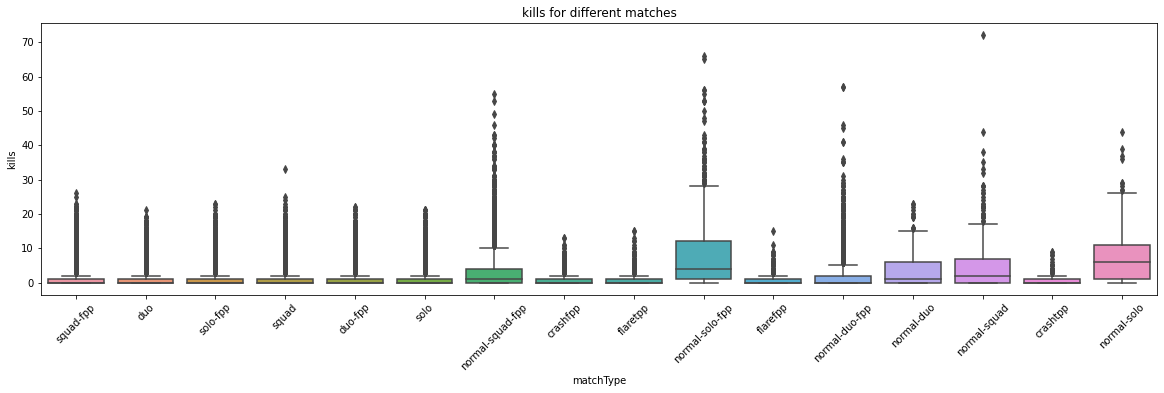

In [31]:
fig, axes = plt.subplots(figsize=(20,5))
sns.boxplot(y='kills', x='matchType', data=dataTrain, ax=axes)
#Plotting box plot between different match type and kills 
plt.xticks(rotation=45)
plt.title('kills for different matches')

As is the above graph 'normal-solo-fpp','normal-squad','normal-duo-fpp' and 'normal-squad-fpp' has got the highest kills this might be because there are lots of cheaters in these match types as discussed above.

Let's see which match has the highest playing percentage.

([<matplotlib.patches.Wedge at 0x7f41cdfb9700>,
 [Text(-0.24360425276394282, 1.072686798667403, 'duo'),
  Text(-1.006881442576672, 0.4429331333223113, 'duo-fpp'),
  Text(-1.0021955755125085, -0.45343580408162737, 'solo'),
  Text(-0.6517159987046055, -0.8861525021306765, 'solo-fpp'),
  Text(0.21234703562374588, -1.079309379400461, 'squad'),
  Text(1.0440871983668416, 0.34623968895330287, 'squad-fpp')],
 [Text(-0.1328750469621506, 0.5851018901822197, '7.11%'),
  Text(-0.5492080595872755, 0.24159989090307887, '22.59%'),
  Text(-0.5466521320977319, -0.24732862040816037, '4.12%'),
  Text(-0.3554814538388757, -0.4833559102530962, '12.17%'),
  Text(0.11582565579477047, -0.5887142069457059, '14.20%'),
  Text(0.5695021082000953, 0.18885801215634698, '39.81%')])

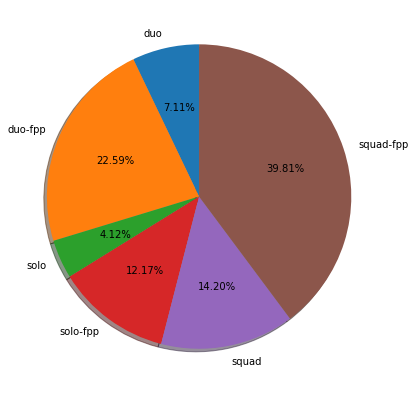

In [32]:
match_count = dataTrain.groupby(['matchType']).size().reset_index()
#total size (count) of each match in match type

match_count[0] = match_count[0]/dataTrain.shape[0]*100
#playin % of each match 

match_count.drop(match_count[match_count[0]<1].index, axis=0, inplace=True)
#Deleting the match which have playing percentage less than 1% 

fig, ax1 = plt.subplots(figsize=(16,7))
ax1.pie(match_count[0], labels=match_count['matchType'], autopct= '%1.2f%%', shadow=True, startangle=90)

From the pie chart it is clear that the players like to play fpp(First Person Perspective) matches rather than classic'solo','duo',or 'squad'. The playing percentage of 'normal-solo-fpp','normal-squad','normal-duo-fpp'and'normal-squad-fpp'is less than 0% as most cheaters like to play in this match. 
Let's see how kills and win Percentage(winPlacePerc) are related to each other in each match type. 

Text(0.5, 1.0, 'Win percentage vs Kills ofr different matches')

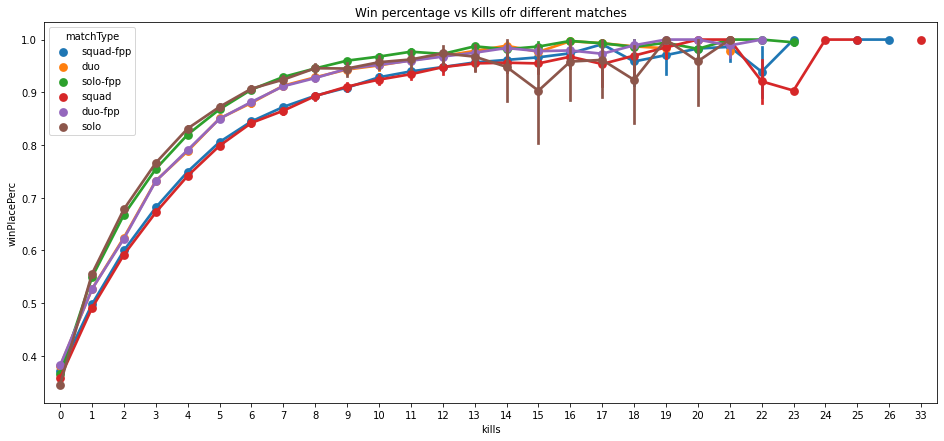

In [33]:
match_to_keep = ['squad-fpp','squad','solo-fpp','solo','duo-fpp','duo']
most_match = dataTrain[dataTrain.matchType.isin(match_to_keep)] 
#Getting only matches with has playing % more than 1 

fig, ax1 = plt.subplots(figsize=(16,7))
sns.pointplot(x='kills', y='winPlacePerc', hue='matchType', data=most_match, ax=ax1)
plt.title('Win percentage vs Kills of different matches')

## Now let us get our model to be prepaired 

In [34]:
# Memory saving function credit to https://www.kaggle.com/gemartin/load-data-reduce-memory-usage

def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe 
    and modify the data type
        to reduce memory usage.
    """ 
    #start_mem = df.memory_usage().sum() / 1024**2
    #print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype 
        
        if col_type != object: 
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int': 
                
                if c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max: 
                    df[col] = df[col].astype(np.int64) 
                else: 
                    if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                        df[col] = df[col].astype(np.float16)
                    elif c_min  > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32) 
                    else:
                        df[col] = df[col].astype(np.float64) 
                        #end_mem = df.memory_usage().sum() / 1024**2
    #print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    #print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

In [35]:
dataTrain = reduce_mem_usage(dataTrain)
dataTrain.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4446965 entries, 0 to 4446965
Data columns (total 27 columns):
 #   Column              Dtype  
---  ------              -----  
 0   Id                  object 
 1   groupId             object 
 2   matchId             object 
 3   assists             int16  
 4   damageDealt         float64
 5   DBNOs               int16  
 6   killPlace           int16  
 7   killPoints          int16  
 8   kills               int16  
 9   killStreaks         int16  
 10  longestKill         float64
 11  matchDuration       int16  
 12  matchType           object 
 13  maxPlace            int16  
 14  numGroups           int16  
 15  revives             int16  
 16  teamKills           int16  
 17  vehicleDestroys     int16  
 18  weaponsAcquired     int16  
 19  winPoints           int16  
 20  winPlacePerc        float64
 21  overAllDistance     float64
 22  headShotPercentage  float64
 23  killsPerDistance    float64
 24  totalBoosts/Heals   int1

In [36]:
dataTest = reduce_mem_usage(dataTest)
dataTest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1934174 entries, 0 to 1934173
Data columns (total 26 columns):
 #   Column              Dtype  
---  ------              -----  
 0   Id                  object 
 1   groupId             object 
 2   matchId             object 
 3   assists             int16  
 4   damageDealt         float64
 5   DBNOs               int16  
 6   killPlace           int16  
 7   killPoints          int16  
 8   kills               int16  
 9   killStreaks         int16  
 10  longestKill         float64
 11  matchDuration       int16  
 12  matchType           object 
 13  maxPlace            int16  
 14  numGroups           int16  
 15  revives             int16  
 16  teamKills           int16  
 17  vehicleDestroys     int16  
 18  weaponsAcquired     int16  
 19  winPoints           int16  
 20  overAllDistance     float64
 21  headShotPercentage  float64
 22  killsPerDistance    float64
 23  totalBoosts/Heals   int16  
 24  damagePerKill       floa

In [37]:
predictors = ["kills",
                "maxPlace",
                "numGroups",
                "overAllDistance",
                "totalBoosts/Heals",
                "revives",
                "killStreaks",
                "weaponsAcquired",
                "winPoints",
                "sKill",
                "assists",
                "damageDealt",
                "DBNOs",
                "killPlace",
                "killPoints",
                "vehicleDestroys",
                "longestKill"]
print(len(predictors))

17


In [38]:
X_train = dataTrain[predictors]
X_train.head()

,kills,maxPlace,numGroups,overAllDistance,totalBoosts/Heals,revives,killStreaks,weaponsAcquired,winPoints,sKill,assists,damageDealt,DBNOs,killPlace,killPoints,vehicleDestroys,longestKill
0,0,28,26,244.8000,0,0,0,1,1466,0,0,0.00,0,60,1241,0,0.00
1,0,26,25,1445.0445,0,0,0,5,0,0,0,91.47,0,57,0,0,0.00
2,0,50,47,161.8000,0,0,0,2,0,0,1,68.00,0,47,0,0,0.00
3,0,31,30,202.7000,0,0,0,3,0,0,0,32.90,0,75,0,0,0.00
4,1,97,95,49.7500,0,0,1,2,0,0,0,100.00,0,45,0,0,58.53


In [39]:
y_train = dataTrain['winPlacePerc']
y_train.head(10)

0    0.4444
1    0.6400
2    0.7755
3    0.1667
4    0.1875
5    0.0370
6    0.0000
7    0.7368
8    0.3704
9    0.2143
Name: winPlacePerc, dtype: float64

## Build The Model 

In [40]:
lgb_reg = lgb.LGBMRegressor(objective='regression',num_leaves=150,
                            learning_rate=0.05,n_estimators=1000,
                            max_bin = 20, bagging_fraction = 0.9, boosting_type='gbdt',
                            bagging_freq = 8, feature_fraction = 0.8, metric='rmse')
lgb_reg.fit(X_train, y_train)

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9


LGBMRegressor(bagging_fraction=0.9, bagging_freq=8, feature_fraction=0.8,
              learning_rate=0.05, max_bin=20, metric='rmse', n_estimators=1000,
              num_leaves=150, objective='regression')

In [41]:
X_test = dataTest[predictors]
X_test.head()

,kills,maxPlace,numGroups,overAllDistance,totalBoosts/Heals,revives,killStreaks,weaponsAcquired,winPoints,sKill,assists,damageDealt,DBNOs,killPlace,killPoints,vehicleDestroys,longestKill
0,0,28,28,588.0,0,0,0,1,0,0,0,51.46,0,73,0,0,0.00
1,2,48,47,6686.0,6,2,1,6,0,0,0,179.10,0,11,0,0,361.90
2,0,28,27,787.8,4,0,0,4,0,0,1,23.40,0,49,0,0,0.00
3,0,45,44,1812.0,0,0,0,3,0,0,0,65.52,0,54,0,0,0.00
4,3,28,27,2963.0,5,1,1,4,0,2,0,330.20,1,7,0,0,60.06


## predict model 

In [42]:
y_pred = lgb_reg.predict(X_test)
y_pred

array([0.26050388, 0.91649459, 0.71534811, ..., 0.88557117, 0.87906778,
       0.05076587])

In [43]:
len(y_pred[y_pred > 1])

398

In [44]:
y_pred[y_pred > 1] = 1
len(y_pred[y_pred > 1])

0

In [45]:
ss = ShuffleSplit(n_splits=10)
scores = cross_val_score(lgb_reg, X_train, y_train, cv=ss)
print(scores)

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will b

In [46]:
accuracy = scores.mean()
print(accuracy) 

0.9026667532977426


## Thank you
Eng.Omar_Alsaabi